In [2]:
import os
os.environ[ "TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.compat.v1.logging.set_verbosity( tf.compat.v1.logging.ERROR)
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series( x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None):
	plt.figure( figsize=( 10, 6))

	if type( y) is tuple:
		for y_curr in y:
			plt.plot( x[ start:end], y_curr[ start:end], format)
	else:
		plt.plot( x[ start:end], y[ start:end], format)

	plt.xlabel( xlabel)
	plt.ylabel( ylabel)
	
	if legend:
		plt.legend( legend)

	plt.title( title)

	plt.grid(True)
	
	plt.show()

def trend( time, slope=0):
	series = slope * time
	return series

def seasonal_pattern( season_time):
	return np.where(
		season_time < 0.4,
		np.cos( season_time * 2 * np.pi),
		1 / np.exp( 3 * season_time)
	)

def seasonality( time, period, amplitude=1, phase=0):
	season_time = ( ( time + phase) % period) / period
	return amplitude * seasonal_pattern( season_time)

def noise( time, noise_level=1, seed=None):
	rnd = np.random.RandomState( seed)
	return rnd.randn( len( time)) * noise_level

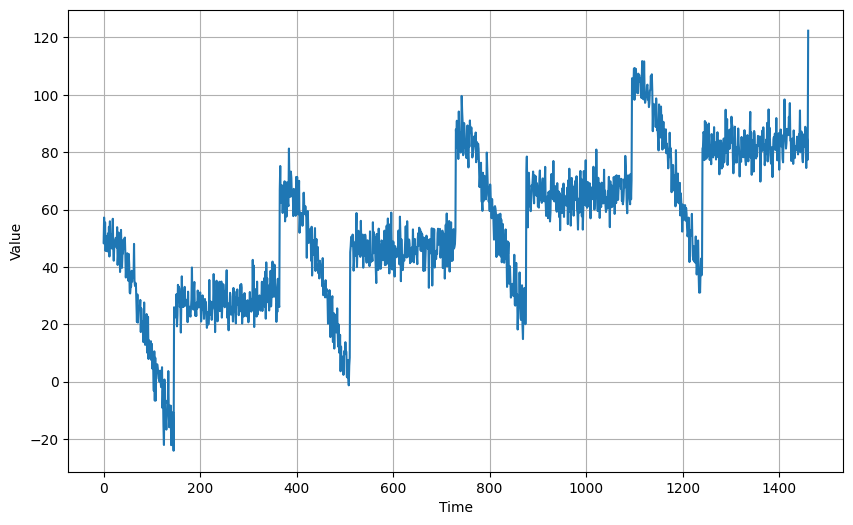

In [4]:
time = np.arange( 4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

series = baseline + trend( time, slope) + seasonality( time, period=365, amplitude=amplitude)

series += noise( time, noise_level)

plot_series( time, series, xlabel="Time", ylabel="Value")

In [5]:
split_time = 1000

time_train = time[ :split_time]
x_train = series[ :split_time]

time_valid = time[ split_time:]
x_valid = series[ split_time:]

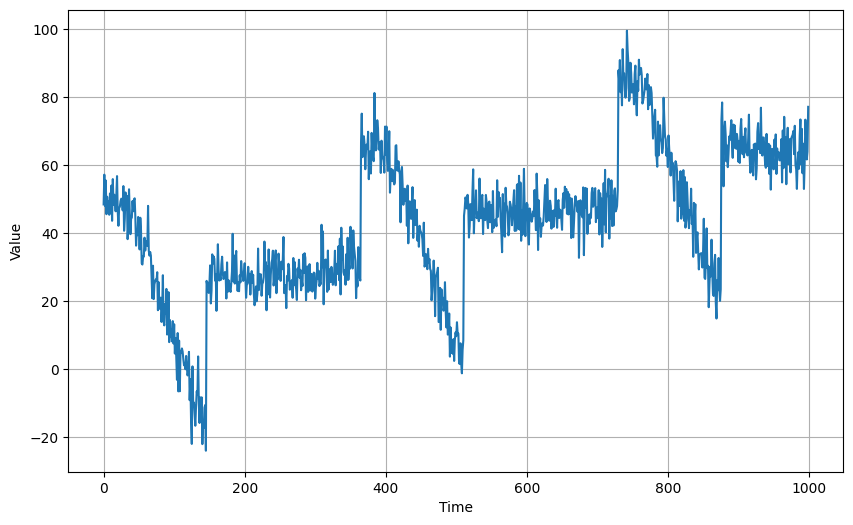

In [6]:
plot_series( time_train, x_train, xlabel="Time", ylabel="Value")

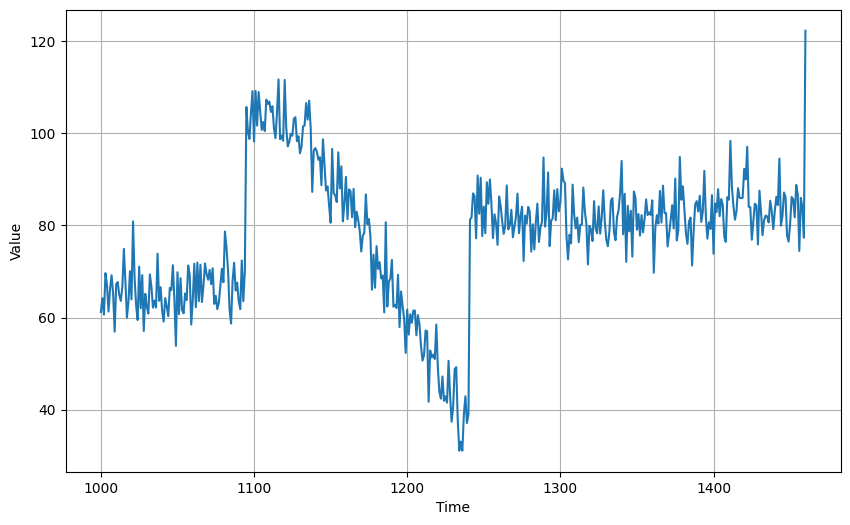

In [7]:
plot_series( time_valid, x_valid, xlabel="Time", ylabel="Value")

In [8]:
def windowed_dataset( series, window_size, batch_size, shuffle_buffer):
	dataset = tf.data.Dataset.from_tensor_slices( series)
	
	dataset = dataset.window( window_size + 1, shift=1, drop_remainder=True)

	dataset = dataset.flat_map( lambda window: window.batch( window_size + 1))

	dataset = dataset.map( lambda window: ( window[ :-1], window[ -1]))

	dataset = dataset.shuffle( shuffle_buffer)

	dataset = dataset.batch( batch_size).prefetch( 1)

	return dataset

In [9]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [10]:
dataset = windowed_dataset( x_train, window_size, batch_size, shuffle_buffer_size)

In [11]:
model_tune = tf.keras.models.Sequential( [
	tf.keras.layers.Conv1D(
		filters=64,
		kernel_size=3,
		strides=1,
		padding="causal",
		activation="relu",
		input_shape=[ window_size, 1]
	),
	tf.keras.layers.LSTM( 64, return_sequences=True),
	tf.keras.layers.LSTM( 64),
	tf.keras.layers.Dense( 1),
	tf.keras.layers.Lambda( lambda x: x * 400.0)
])

init_weight = model_tune.get_weights()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
	lambda epoch: 1e-8 * 10 ** ( epoch / 20)
)

optimizer = tf.keras.optimizers.SGD( momentum=0.9)

model_tune.compile(
	loss=tf.keras.losses.Huber(),
	optimizer=optimizer
)

history = model_tune.fit(
	dataset,
	epochs=100,
	callbacks=[ lr_schedule],
	verbose=0
)

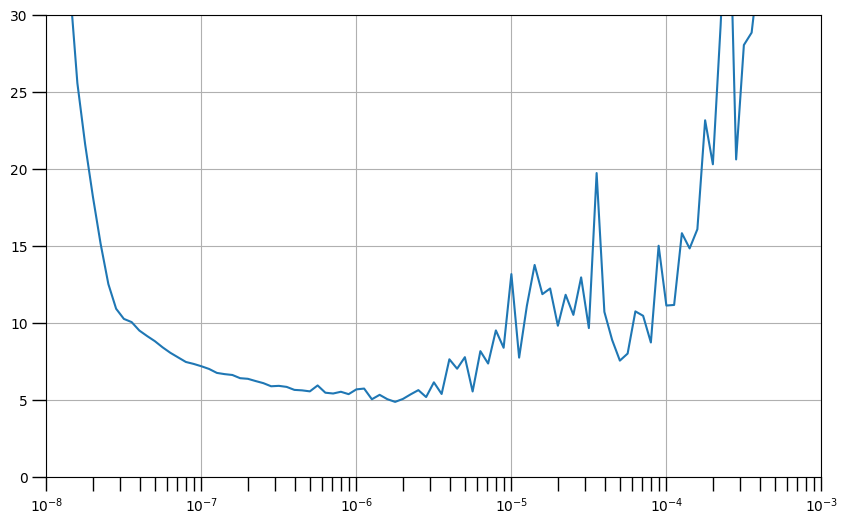

In [12]:
lrs = 1e-8 * ( 10 ** ( np.arange( 100) / 20))

plt.figure( figsize=( 10, 6))

plt.grid( True)

plt.semilogx( lrs, history.history[ "loss"])

plt.tick_params( "both", length=10, width=1, which="both")

plt.axis( [ 1e-8, 1e-3, 0, 30])

plt.show()

In [13]:
model = tf.keras.models.Sequential( [
	tf.keras.layers.Conv1D(
		filters=64,
		kernel_size=3,
		strides=1,
		padding="causal",
		activation="relu",
		input_shape=[ window_size, 1]
	),
	tf.keras.layers.LSTM( 64, return_sequences=True),
	tf.keras.layers.LSTM( 64),
	tf.keras.layers.Dense( 1),
	tf.keras.layers.Lambda( lambda x: x * 400.0)
])

model.set_weights( init_weight)

optimizer = tf.keras.optimizers.SGD(
	learning_rate=2e-7,
	momentum=0.9
)

model.compile(
	loss=tf.keras.losses.Huber(),
	optimizer=optimizer,
	metrics=[ "mae"]
)

history = model.fit(
	dataset,
	epochs=100,
	verbose=0
)

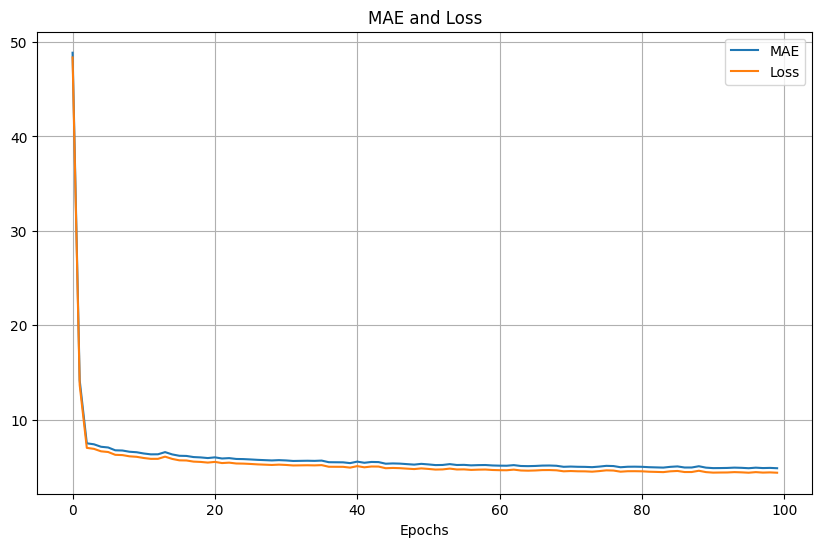

In [14]:
loss = history.history[ "loss"]
mae = history.history[ "mae"]

epochs = range( len( loss))

plot_series(
	x=epochs,
	y=( mae, loss),
	title="MAE and Loss",
	xlabel="Epochs",
	legend=[ "MAE", "Loss"]
)

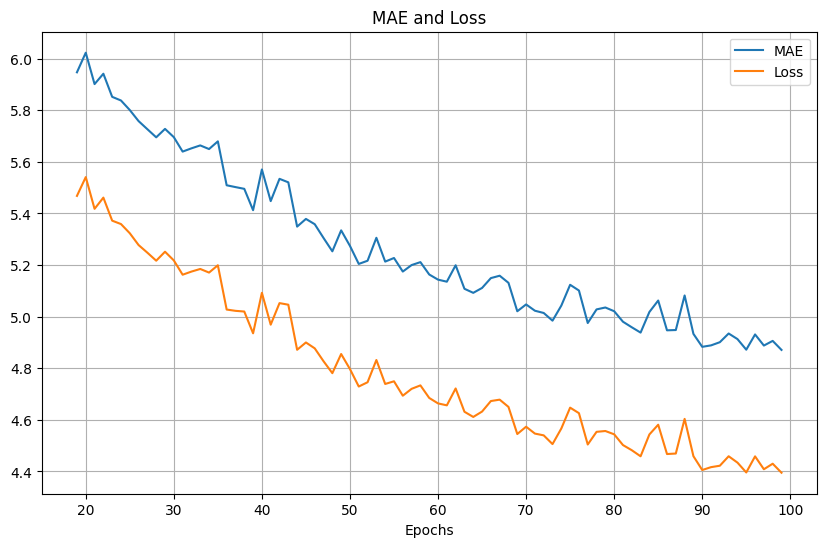

In [15]:
zoom_split = int( epochs[ -1] * 0.2)
epochs_zoom = epochs[ zoom_split:]
mae_zoom = mae[ zoom_split:]
loss_zoom = loss[ zoom_split:]


plot_series(
	x=epochs_zoom,
	y=( mae_zoom, loss_zoom),
	title="MAE and Loss",
	xlabel="Epochs",
	legend=[ "MAE", "Loss"]
)

In [16]:
def model_forecast( model, series, window_size, batch_size):

	dataset = tf.data.Dataset.from_tensor_slices( series)

	dataset = dataset.window( window_size, shift=1, drop_remainder=True)

	dataset = dataset.flat_map( lambda w: w.batch( window_size))

	dataset = dataset.batch( batch_size).prefetch( 1)

	forecast = model.predict( dataset, verbose=0)

	return forecast

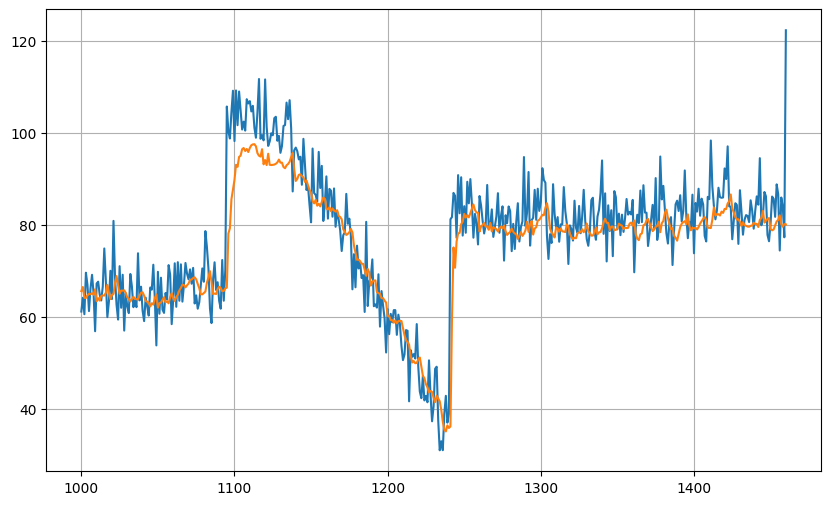

In [17]:
forecast_series = series[ split_time - window_size:-1]

forecast = model_forecast( model, forecast_series, window_size, batch_size)

results = forecast.squeeze()

plot_series( time_valid, ( x_valid, results))

In [18]:
print( tf.keras.metrics.mean_squared_error( x_valid, results).numpy())
print( tf.keras.metrics.mean_absolute_error( x_valid, results).numpy())

50.42378
5.097728
